
### Sliding Mode Control
![alt text](SMC_image.png)

We have an UAV that we wish to design a GN&C system in which it starts to follow a path. The setting o fthe dynamics is shown above and the following parameters will describe the system mathematically:
- Lateral acceleration $a_m$
-  Heading angle (of the UAV) $\psi$
- Speed/velocity $v$
- Corrdinate velocity components $\dot{x} v cos(\psi) ,\; \dot{y} = v sin(\psi)$
- Heading angular velocity $\dot{\psi} = \frac{a_m}{v}$

From this, the idea is to use $a_m$ as a control input so that the UAV is steered towards and follows the desired path.

This will be deone according to [Kumar et. al.](https://www.sciencedirect.com/science/article/pii/S240589632300294X), where the guidance design takes the shape of an outer feedback loop involving a sliding mode controller, compensated by an inner sliding mode control loop that models the defects of having a system lag, due to physical properties of the UAV, like air viscosity, actuators etc.
![alt text](GNC_loop.png)
We will start out by designing the Guiance system, that aims to guide the UAV to the path.

### Guidance Subsystem

To get the UAV to steer towards the path, we design a dynamic system with regards to $d$, the perpendicular distance to the path. The idea is that a suitable lateral acceleration $a_m$ derived as a control input to a sliding mode controller will nullify $d$.

We can describe the rate of change in $d$ dynamically as $$\dot{d} = v sin(\psi - \psi_d) \Rightarrow \ddot{d} = v\dot{\psi} cos(\psi - \psi_d) - \dot{\psi}_s v cos(\psi-\psi_d)$$

Remembering that $\dot{\psi} = \frac{a_m}{v}$, we get that 

$$\ddot{d} = a_m cos(\psi - \psi_d) + \Delta \tag{1},$$ 
where we've assumed to lack enough path curvature information to describe the other term as anything else but a bounded uncertainty,
$$\Delta = -\dot{\psi}_d vcos(\psi-\psi_d), \;\; |\Delta| \le \Delta_{max} < \infty$$
Now at the outer loop, we from now on use the notation $a_m^c$ and use sliding mode control based on $(1)$ to drive the state $x = (d, \dot{d})$ towards the sliding surface 
$$S_d = d + \frac{1}{\beta_d} \dot{d}^{\frac{p_d}{q_d}},$$
where $\beta_d > 0$ and $1 < \frac{p_d}{q_d} < 2$.

Time derivation yields
$$\dot{S}_d = \dot{d} + \frac{1}{\beta_d}\frac{p_d}{q_d}\dot{d}^{\frac{p_d}{q_d}-1}\ddot{d} = \{ (1) \} = \dot{d} + \frac{1}{\beta_d}\frac{p_d}{q_d}\dot{d}^{\frac{p_d}{q_d}-1}\cdot \left(a_m^c cos(\psi-\psi_d) + \Delta\right)$$

Now, from the Lyapunov candidate $\mathcal{V} = \frac{1}{2}S_d^2$, we arrive at the condition $\dot{\mathcal{V}} = S_d \dot(S_d) < 0 \;\; \forall S \neq 0$, which after some math yields
$$a_m^c = \frac{1}{cos(\psi-\psi_d)}\left[\beta_d \frac{p_d}{q_d} \dot{d}^{2-\frac{p_d}{q_d}} + \eta sign(S_d)\right]$$
which by the way also manages to show that $\dot{d} = 0$ is not an attraction point (look in the [article](https://www.sciencedirect.com/science/article/pii/S240589632300294X)).

In [44]:
include("GuidanceDesign.jl")

simulate! (generic function with 5 methods)

### Define the parameters

In [45]:
GP = GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0))

GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0))

In [46]:
include("path_creator.jl")

plot_guidance_paths

### Straight line path case
First, we make sure the sliding mode controller works for the straight line path, in this case starting at $p_1 = (10,10)$ and ending at $p_2 = (155, 155)$:

!["alt_text"](straight_line.png)

Matheamatically, we can descive the orthogonal distance as $$d = R \sin(\theta - \psi_d)$$

In [47]:
p₁ = (10, 10)
p₂ = (155, 155)
str_l_path = straight_line_path([p₁, p₂]);


In [48]:
SP = SimParams(GP, 10)

SimParams(GuidanceParams(1.0, S_d(1.0, 15, 13, 30.0)), 10.0)

### Define the initial state
We simulate the response of the sliding mode controller for two different initial positions: $(x_0, y_0) = (10, 20)$ and $(x_0, y_0) = (10,0)$. We assume that the flight path angle points $0.1$ radians away from the horisontal axis: $\psi_0 = 0.1$
### Simple geometry for straight reference line path angle:
In this case, we shall follow a straight line. Thus, we just let $\psi_d = \arctan{\Delta p^2, \Delta p^1}$

In [49]:
init_pos1 = [10, 20];
init_pos2 = [10, 0];
psi = 0.1;

x_dot_init = [SP.v * cos(psi), SP.v * sin(psi)]

SP = SimParams(GP, 10)
psi_d = atan((p₂[2]-p₁[2])/(p₂[1]-p₁[1]));

### Simulate the response
Having given the initial conditions, we simulate the response and obtain the result

In [50]:
using LinearAlgebra
X1, Y1 = simulate!(SP, psi, psi_d, init_pos1,"straight_line")
X2, Y2 = simulate!(SP, psi, psi_d, init_pos2, "straight_line")

([10.0, 10.099500416527803, 10.19863509714181, 10.29731372171963, 10.395450133301866, 10.492961639873364, 10.589768433766034, 10.685793101651438, 10.780960204990542, 10.87519591565188  …  144.64044635053733, 144.71208689157388, 144.78161725589064, 144.85329001729122, 144.92285400145138, 144.99455894600422, 145.06415650917592, 145.13589359567328, 145.20552469294887, 145.2772938762238], [0.0, 0.009983341664682815, 0.02311022627447505, 0.03931297454227688, 0.05852871605183041, 0.08069865259113046, 0.10576745105101308, 0.13368273642476547, 0.16439466313157147, 0.1978555482984738  …  144.70326443935355, 144.77303286258348, 144.84490447337646, 144.91463979637146, 144.9864788672714, 145.05618109769964, 145.12798763779566, 145.19765678750247, 145.2694308099075, 145.33906689489257])

### Circular Path
Having reached success with the straight line path, the UAV now follows a circular path.

!["A Circular Path"](circular.png)

Instead, we see that $$d = R' - R,$$ which get a bit more tricky to implement in code, along with the reference path angle, $\psi_d$. This is done numerically!

### Initial State
We let the circular path be centered in the origin with a radius of $R=20$

In [51]:
c = [0, 0];
R = 25;

circ_path = circular_path(c, R);

### Initial States
We try out $(x_0, y_0) = (-20, 10)$ and $(x_0, y_0) = (-20, 25)$, at an initial flight path angle pf $\psi_0 = 0.1$ radians.

In [52]:
init_pos1 = [-20, 10];
init_pos2 = [-20, 25];


psi = 0.0;
SP = SimParams(GP, 10);

Calculate the closest point on the path to the UAV, q

In [53]:
X1_c, Y1_c = simulate!(SP, psi, 0, init_pos1, "circular", 500, 0.01, R)
X2_c, Y2_c = simulate!(SP, psi, 0, init_pos2, "circular", 500, 0.01, R)

([-20.0, -19.9, -19.80004946755224, -19.700243746881686, -19.6006735224639, -19.501425649424007, -19.40176423140516, -19.30239474076829, -19.203401610005585, -19.10392605293372  …  22.75089966574555, 22.79169616290224, 22.835193470178375, 22.875943004198344, 22.913924316799125, 22.954623869180807, 22.9925632646305, 23.03322896236416, 23.071122676713554, 23.11175130244015], [25.0, 25.0, 25.00314500610638, 25.009375425147823, 25.01863665667457, 25.030878376204818, 25.0391004050586, 25.05031219932041, 25.06446705932672, 25.07469513564838  …  10.550480467462132, 10.45918070941347, 10.369136363340408, 10.277815634712372, 10.185309311181914, 10.093966295926611, 10.00144277311802, 9.91008468082273, 9.817542439587676, 9.726167854655278])

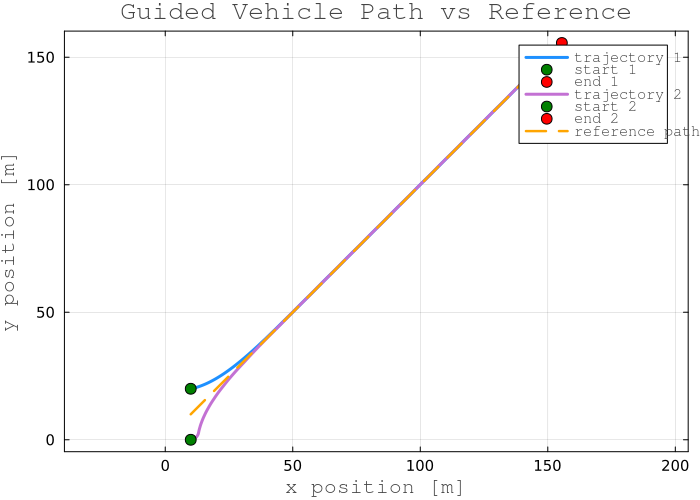

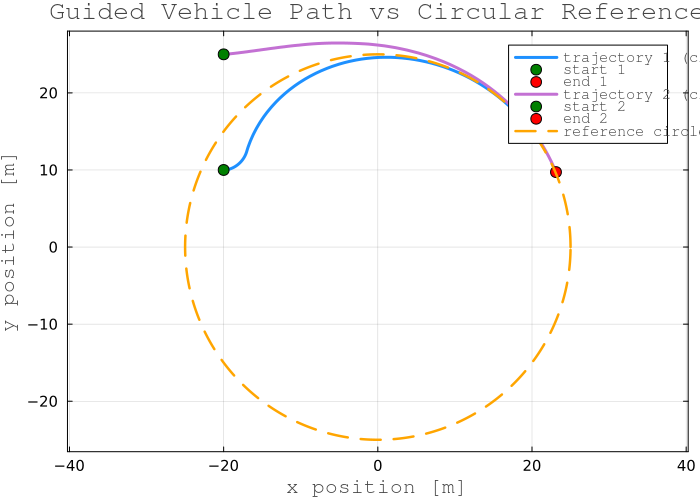

In [57]:
p_str_l = plot(
    X1, Y1;
    label = "trajectory 1",
    xlabel = "x position [m]",
    ylabel = "y position [m]",
    title = "Guided Vehicle Path vs Reference",
    lw = 3,
    color = :dodgerblue,
    legend = :topright,
    grid = true,
    framestyle = :box,
    aspect_ratio = :equal,
    size = (700, 500),
    fontfamily = "sans",
    tickfont = font(10),
)

# Mark start and end points of trajectory 1
scatter!(p_str_l, [X1[1]], [Y1[1]];
    label = "start 1",
    color = :green,
    markersize = 6,
)
scatter!(p_str_l, [X1[end]], [Y1[end]];
    label = "end 1",
    color = :red,
    markersize = 6,
)

# Trajectory 2
plot!(p_str_l, X2, Y2;
    label = "trajectory 2",
    lw = 3,
)
scatter!(p_str_l, [X2[1]], [Y2[1]];
    label = "start 2",
    color = :green,
    markersize = 6,
)
scatter!(p_str_l, [X2[end]], [Y2[end]];
    label = "end 2",
    color = :red,
    markersize = 6,
)

# Reference path
plot!(p_str_l, str_l_path[:, 1], str_l_path[:, 2];
    label = "reference path",
    lw = 2.5,
    linestyle = :dash,
    color = :orange,
)

display(p_str_l)

p_circ = plot(
    X1_c, Y1_c;
    label = "trajectory 1 (circ)",
    xlabel = "x position [m]",
    ylabel = "y position [m]",
    title = "Guided Vehicle Path vs Circular Reference",
    lw = 3,
    color = :dodgerblue,
    legend = :topright,
    grid = true,
    framestyle = :box,
    aspect_ratio = :equal,
    size = (700, 500),
    fontfamily = "sans",
    tickfont = font(10),
)

scatter!(p_circ, [X1_c[1]], [Y1_c[1]];
    label = "start 1",
    color = :green,
    markersize = 6,
)
scatter!(p_circ, [X1_c[end]], [Y1_c[end]];
    label = "end 1",
    color = :red,
    markersize = 6,
)

plot!(p_circ, X2_c, Y2_c;
    label = "trajectory 2 (circ)",
    lw = 3,
)
scatter!(p_circ, [X2_c[1]], [Y2_c[1]];
    label = "start 2",
    color = :green,
    markersize = 6,
)
scatter!(p_circ, [X2_c[end]], [Y2_c[end]];
    label = "end 2",
    color = :red,
    markersize = 6,
)

plot!(p_circ, circ_path[1], circ_path[2];
    label = "reference circle",
    lw = 2.5,
    linestyle = :dash,
    color = :orange,
)

display(p_circ)


### Results
As seen above, we manage to follow the paths. Success!